# Reduced Order Models (ROM)

**Students:**

Guilherme Marim - RA: 232092

## Objective

Get a **Reduce Order Model** to solve the Kuramoto-Sivashinsk equation using a Neural Network (NN).

Kuramoto-Sivashinsk equation: 

\begin{equation}
    u_{t} + uu_{x} + \alpha u_{xx} + \gamma u_{xxxx} = 0
\end{equation}

The dataset that will be used to solve this equation by the NN was obtained using the finite diference method and the initial condition was extracted of the bellow function:

\begin{equation}
    u(x,t=0) = cos(\frac{\pi x}{20})(1 - sin(\frac{\pi x}{20}))
\end{equation}

## Loading Dataset

**Loading Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Loading DataSet Kuramoto-Sivashinsky**

In [2]:
X = np.load('D:/Guilherme/Mestrado/disciplinas/metodos_numericos_redes_neurais/Parte 3/meus_notebooks/Kuramoto_X.npy')
T = np.load('D:/Guilherme/Mestrado/disciplinas/metodos_numericos_redes_neurais/Parte 3/meus_notebooks/Kuramoto_T.npy')
U = np.load('D:/Guilherme/Mestrado/disciplinas/metodos_numericos_redes_neurais/Parte 3/meus_notebooks/Kuramoto_U.npy')

In [3]:
U.shape

(40001, 256)

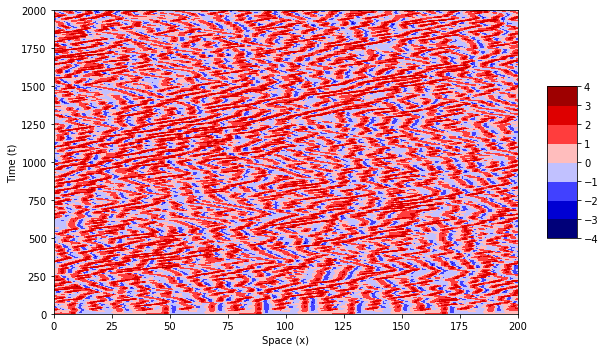

In [4]:
def plot_data(X, T, U, title=''):
    fig, ax = plt.subplots(figsize=(9, 5))

    surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.xlabel('Space (x)')
    plt.ylabel('Time (t)')
    plt.tight_layout()

plot_data(X, T, U)

In [5]:
U.shape

(40001, 256)

In [6]:
def plot_data_compare(X, T, U, U_reduced, k, variance, title_1='Original data', title_2='Reduced data', title_3='Absolute difference'):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 7))
    plt.suptitle(f'Training set reconstruction with {k} components ({round(variance, 2)}% variance)', y=1.02)

    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title(title_1)
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_reduced, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title(title_2)

    surf3 = ax[2].contourf(X, T, abs(U - U_reduced), cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title(title_3)

    plt.tight_layout()

    print(f'Mean error {round(abs(U - U_reduced).mean(), 2)}')

In [7]:
def plot_time_serie(u_original, u_reconstruct, time=0):
    plt.figure(figsize=(18, 4))
    plt.title("Time serie")
    plt.subplot(1, 3, 1)
    plt.plot(u_original[time,:])
    plt.title('Original data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 2)
    plt.plot(u_reconstruct[time,:])
    plt.title('Predicted data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')

    plt.subplot(1, 3, 3)
    plt.plot(u_original[time,:])
    plt.plot(u_reconstruct[time,:])
    plt.title('Both data')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()

**Taking out the first 200 seconds**

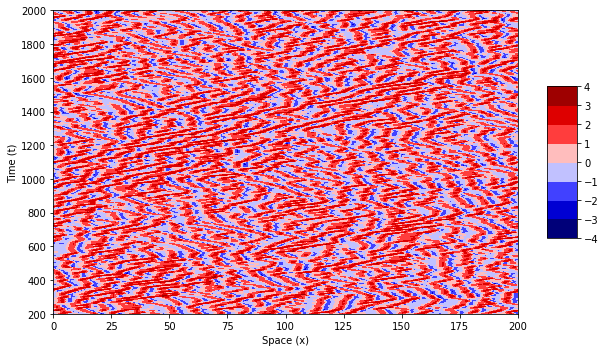

In [8]:
# Taking out the first 200 seconds
U = U[4000:,:]
X = X[4000:,:]
T = T[4000:,:]

plot_data(X, T, U)

In [9]:
U.shape

(36001, 256)

## Preprocessing

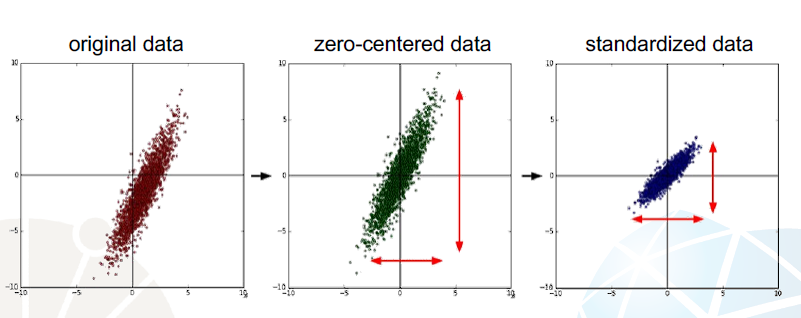

### Standardization

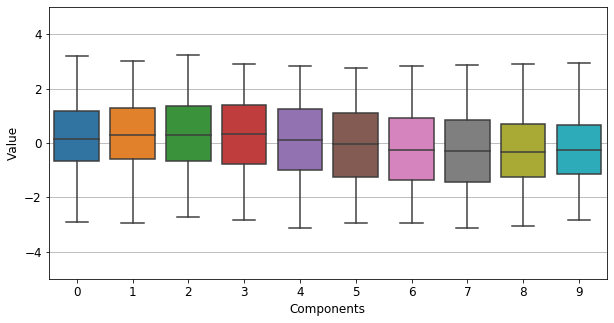

In [10]:
#Data analysis with barplot
def barplot(X,plot='none', figsize=(10,5)):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=figsize)
    if (plot!='auto'):
        plt.ylim(-5,5)
    plt.xlabel('Components')
    plt.ylabel('Value')
    plt.grid(True, zorder=1)
    Xdf = pd.DataFrame(X)
    bp = sns.boxplot(data=Xdf)

barplot(U[:,100:110])

__Centralization.__ Data will be shifted to have $\mu$=0, where $\mu$ is the mean.

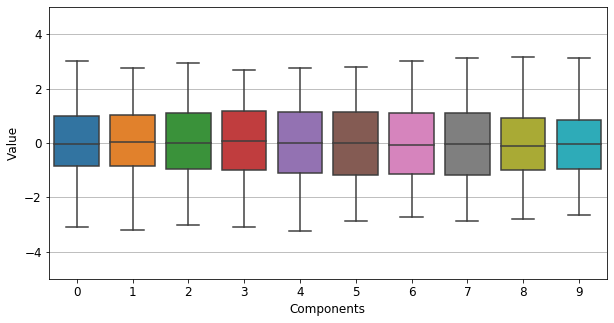

In [11]:
# Centering data
def centralize(X):
    dims = X.shape[1]
    X_m = X.copy()
    for i in range(0, dims):
        mean = X[:,i].mean()       
        for j in range(0, len(X)):
            X_m[j][i] = X[j][i] - mean
    return X_m

Uc = centralize(U)
barplot(Uc[:,100:110])

__Standardization.__ `StandardScaler` will standardize features by removing the mean and scaling to unit variance.

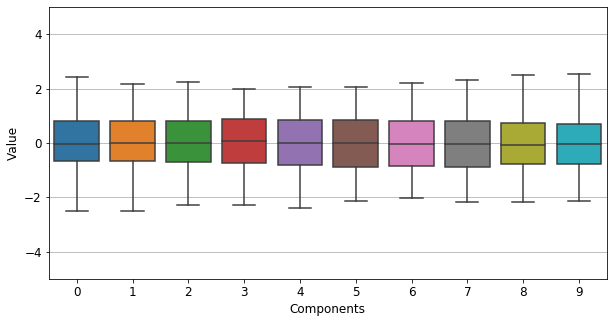

In [12]:
# Standardize data
def standardize(X):    
    Xs = StandardScaler().fit_transform(X)
    return Xs

Us = standardize(U)
barplot(Us[:,100:110])

__Normalization.__ Data will be scaled between 0 and 1

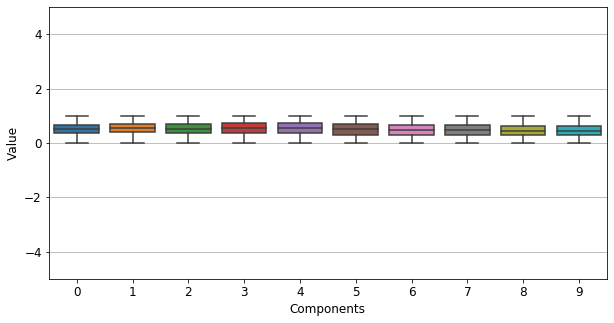

In [13]:
# Normalize data
def normalize(X):    
    Xn = MinMaxScaler().fit_transform(X)
    return Xn

Un = normalize(U)
barplot(Un[:,100:110])

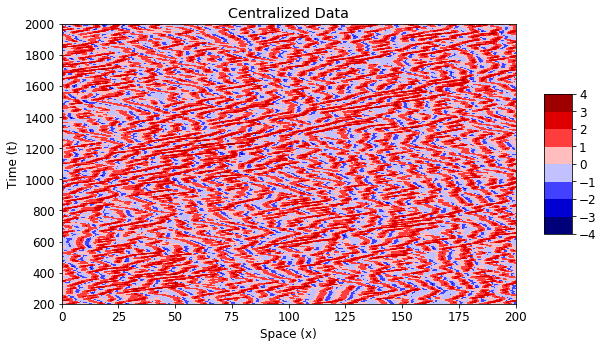

In [14]:
Uc = centralize(U)
plot_data(X, T, Uc, title='Centralized Data')

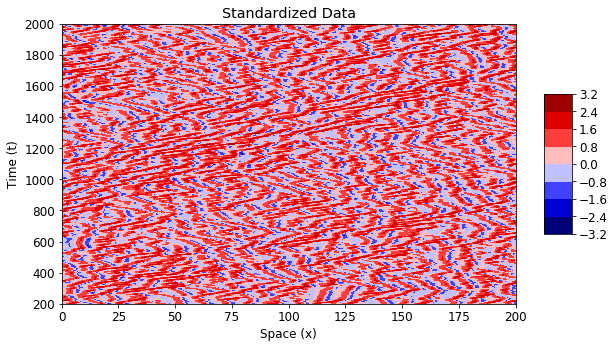

In [15]:
Us = standardize(U)
plot_data(X, T, Us, title='Standardized Data')

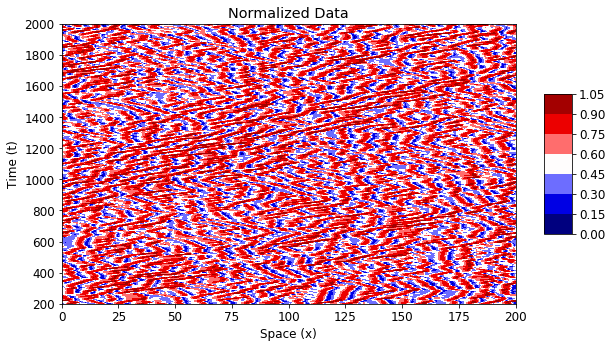

In [16]:
Un = normalize(U)
plot_data(X, T, Un, title='Normalized Data')

## Principal Component Analysist (PCA) using ED

In this section we will proceed the Principal Component Analysis (PCA) using __Eigen-Decomposition__ (ED).

### Covariance Matrix

**Covariance** is a statistical measure of the joint variability of two random variables

**Population covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \mu \right )\cdot \left ( y_i - \nu \right )}{N}
\end{equation}

- $\mu$: mean of the X population, $\nu$: mean of the Y population
- N: number of examples in one set ($N_X = N_Y$)

**Sample covariance:**

\begin{equation}
cov = \frac{\sum_{n}^{i=1}\left ( x_i - \bar{x}\right )\cdot \left ( y_i - \bar{y} \right )}{n-1}
\end{equation}

- $x$: mean of the X sample set, $y$: mean of the Y sample set
- 
n: number of observations in one sample set ($n_X = n_Y$)


__Covariance Matrix.__ 

*Covariance Matrix* example:

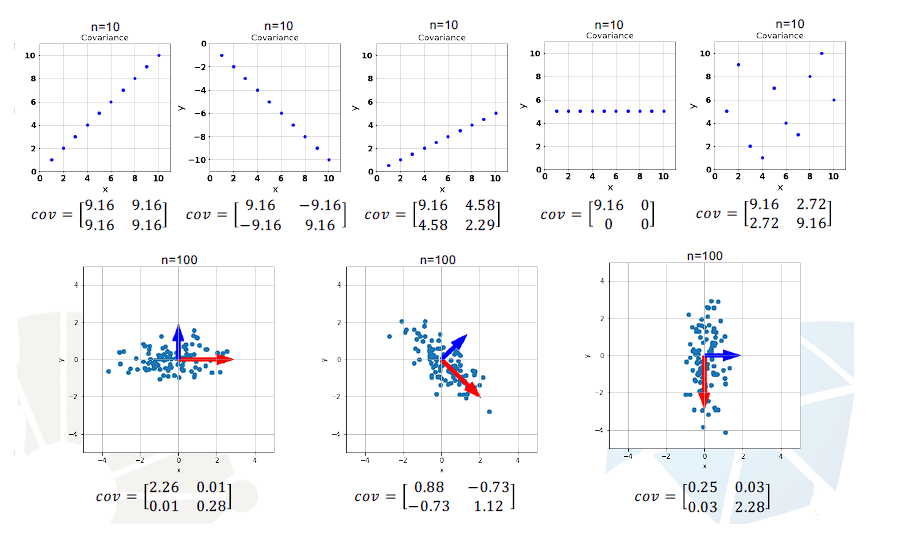


The `numpy` library provides a covariance matrix function `cov`:

In [17]:
# Compute covariance matrix
def covmatrix(X):
    CM = np.cov(X.T)  
    return CM

CM = covmatrix(U)

### Eigenvalues and Eigenvectors

For a given matrix A, an eigenpair ($\vec{e}$,$\lambda$) satisfy:


\begin{equation}
A\cdot \vec{e} = \lambda\cdot \vec{e}
\end{equation}

**Eigenvectors: $\vec{e}$**

- A $𝑛 \times 𝑛$ matrix that is diagonizable have $n$ eigenvectors

**Eigenvalues: $\lambda$**

- $\lambda$ represents the magnitude of the spread in a direction


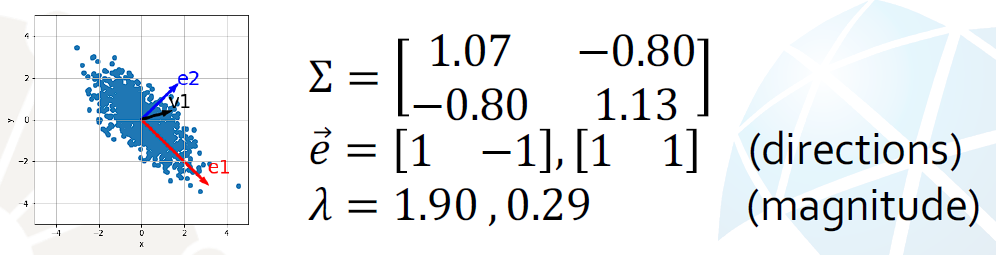

__Calculating Eigenvalues and Eigenvectors.__ The `numpy` library provides a _linear algebra_ package, that returns the Eigenvectors and Eigenvalues (not necessarily ordered).

e = [ $\lambda_1$, $\lambda_2$, $\lambda_3$ ... ]

E = [ [ $e1_1$, $e1_2$, $e1_3$, ... ]


In [18]:
#Compute Eigenvectors and Eigenvalues
def eigen(CM):    
    evalues, evectors = np.linalg.eig(CM)
    return evalues, evectors
e, E = eigen(CM)

### Components Selection

The **percentage of the total variance** of the data in a principal component *$𝑃𝐶_i$* can be expressed by:

\begin{equation}
PC_i = \frac{\lambda_i}{\sum_{p}^{i=1}\lambda_i}\times 100%
\end{equation}

__Components Analysis.__ Checking the percentage of _variance explained_ by each eigenvalue.

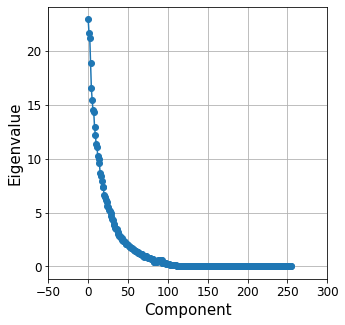

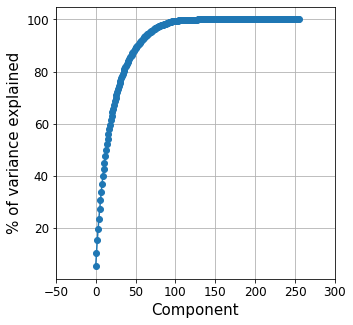

In [19]:
# Components analysis
def component_analysis(e, plot='none'):
    varexp = 100* e/e.sum()
    cumvarexp = np.cumsum(varexp)

    # Plotting Eigenvalues...
    if (plot=='eigen'):
        plt.figure(figsize = (5,5))
        plt.plot(e, '-o')
        plt.grid(True)
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('Eigenvalue', fontsize = 15)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    # Plotting Variance explained...
    if (plot=='varexp'):
        plt.figure(figsize = (5,5))
        plt.plot(cumvarexp, '-o')
        plt.xlabel('Component', fontsize = 15)
        plt.ylabel('% of variance explained', fontsize = 15)
        plt.grid(True)
        xint = []
        locs, labels = plt.xticks()
        for each in locs:
            xint.append(int(each))
        plt.xticks(xint)

    plt.show()

#Viewing.... plot=['eigen', 'varexp']
component_analysis(e, plot='eigen')  
component_analysis(e, plot='varexp')

__Selecting Eigenvectors.__ Let's show the eigenvectors corresponding to the best _k_ eigenvalues:

In [20]:
# Get the k most relevant eigenvalues
def components_select(e, E, k):
    best_index = (-e).argsort()[:k]
    pc = E[:, best_index]
    return pc

### Transforming data

__Transforming data to the new space.__ Now we need to transform the data to the new space with the selected components. At this moment we will transform the original data (U).

In [21]:
# Calculating the eigenmatrix
def transform(X, PC):    
    return np.dot(X, PC)

In [22]:
def inverse_transform(Xpc, PC):
    return np.dot(Xpc, PC.T)

In [23]:
def explained_variance_ratio(e, k):
    varexp = e/e.sum()
    cumvarexp = np.cumsum(varexp)    
    total_modal_energy = cumvarexp[k-1]        
    return total_modal_energy*100

### POD Projection

Function responsible for makes the projection of the **POD** with the **reduced space** that preserves the **greatest energy of the system**

In [24]:
def project(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f'total_modal_energy: {round(total_modal_energy, 2)}%')
    return transform(X, PC), PC, total_modal_energy

### Reconstructs the original space

Function that reconstructs the original space with the modes extracted in the POD projection through the product between the **projected U** and the **modes**

In [25]:
def reconstruct(X_projected, modes):
    return inverse_transform(X_projected, modes)

### Function to calculate the relative error

The relative error is calculate through of the $l^2-norm$ applied to the **original data U** and **reconstructed data U**

The $l^2-norm$ $\mathbf{x}$ is a **vector norm** defined for a **complex vector**

\begin{equation}
    \mathbf{x} = \begin{bmatrix}
    x_{1}\\ 
    x_{2}\\ 
    \vdots\\ 
    x_{n}
    \end{bmatrix}
\end{equation}

by 

\begin{equation}
    \left | \mathbf{x} \right | = \sqrt{\sum_{k=1}^{n} \left | x_{k} \right |^{2}}
\end{equation}

The **relative error** is given by:

\begin{equation}
    \frac{l^2(\Phi _{ori}) - l^2(\Phi _{rec})}{l^2(\Phi _{ori})}
\end{equation}

where, 

$\Phi _{ori}$ = original data U
$\Phi _{rec}$ = reconstructed data U



In [26]:
def POD_error(X_original, X_reconstructed):
    error = 100*np.linalg.norm(X_original - X_reconstructed, 2)
    error /= np.linalg.norm(X_original, 2)    
    print(f'The projection error for POD is {round(error, 2)}%')

### Creating a PCA_ED function

**Eigen-Decomposition (ED)**

- Matrix **decomposition: factorization** of a matrix into a product of matrices
- For square ($𝑛 \times 𝑛$) matrices:

\begin{equation}
A = U\cdot \Lambda \cdot U^{T}
\end{equation}

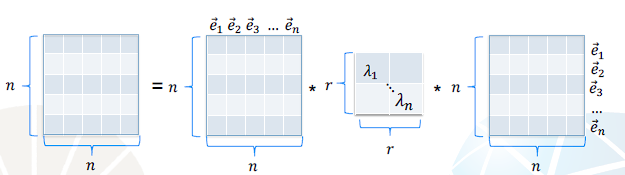

**Algorithm PCA flow using Eigen-Decomposition (ED):**

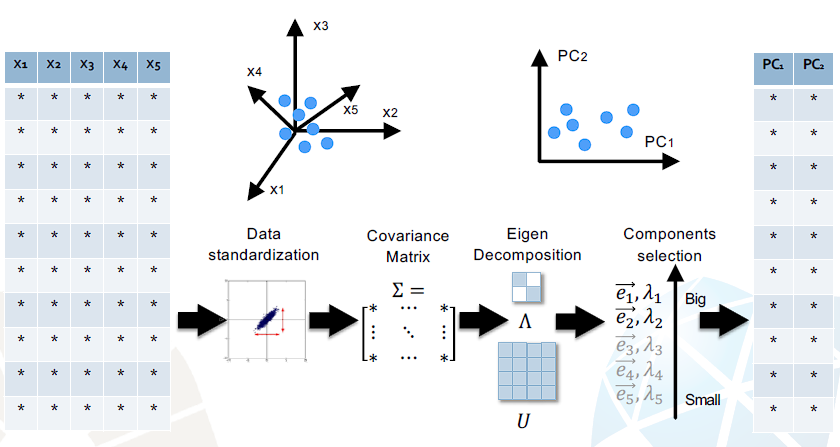



Creating our PCA function using Eigen-Decomposition (ED).

In [27]:
# Creating a PCA function based on EVD
def PCA_ED(X, k):
    CM = covmatrix(X)
    e, E = eigen(CM)
    PC = components_select(e, E, k)
    Xpc = transform(X, PC)       
    Xpc_inv = inverse_transform(Xpc, PC)
    total_modal_energy = explained_variance_ratio(e, k)
    print(f"Modal energy preserved: {round(total_modal_energy, 2)}%")
    component_analysis(e, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

### Creating a PCA_SVD function

**Singular Value Decomposition (SVD):**

- Method for Matrix decomposition

\begin{equation}
A = U\cdot S \cdot V^{T}
\end{equation}

where,

$A$: Covariance Matrix

$U$: Left Singular vectors

$S$: Singular values

$V^{T}$: Right singular vectors

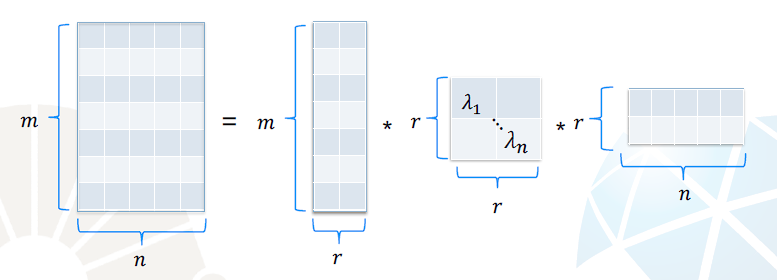

**Algorithm PCA flow using Singular Value Decomposition (SVD):**

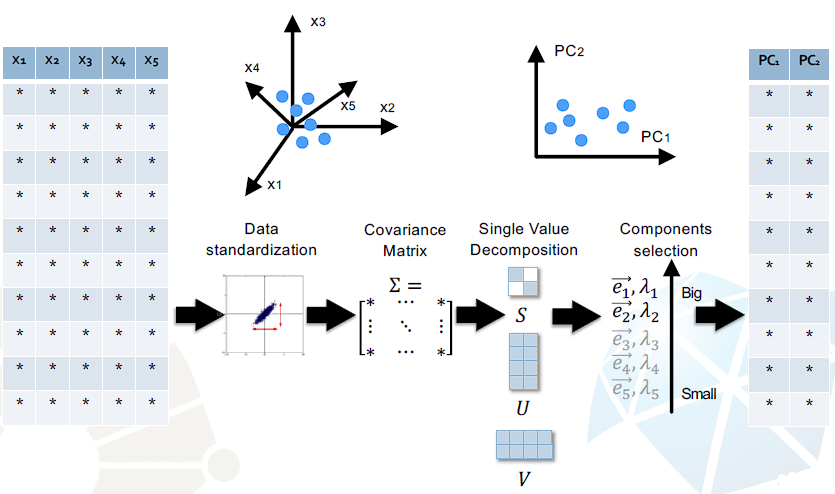


**Creating our PCA function using Singular Value Decomposition (SVD) with Numpy Library.**


In [28]:
# Creating a PCA function using the SVD
def PCA_SVD(X, k):
    CM = covmatrix(X)
    [U, S, V] = svd(CM)
    PC = components_select(S, V, k)
    Xpc = transform(X, PC)
    Xpc_inv = inverse_transform(Xpc, PC)
    total_modal_energy = explained_variance_ratio(S, k)
    print(f"Modal energy preserved: {round(total_modal_energy, 2)}%")
    component_analysis(S, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

**Creating our PCA function using Singular Value Decomposition (SVD) with the SKlearn Library.**

In [29]:
def PCA_SKL(X, k):    
    pca = PCA(n_components=k)
    Xpc = pca.fit_transform(X)
    Xpc_inv = pca.inverse_transform(Xpc)
    PC = pca.components_.T
    total_modal_energy = pca.explained_variance_ratio_.sum()
    print(f"Modal energy preserved: {round(total_modal_energy*100, 2)}%")
    pca_explain = PCA(n_components=256)
    pca_explain.fit_transform(X)
    component_analysis(pca_explain.explained_variance_, plot='varexp')
    return Xpc_inv, Xpc, PC, total_modal_energy

## Compare Results

### Results for PCA ED

**Original Data**

In [30]:
k=100

Modal energy preserved: 99.36%


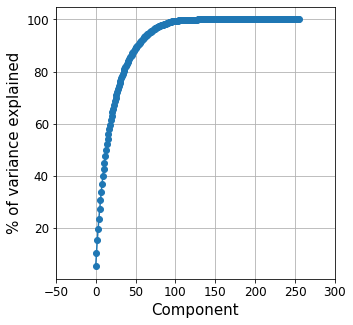

Mean error 0.08
The projection error for POD is 10.47%


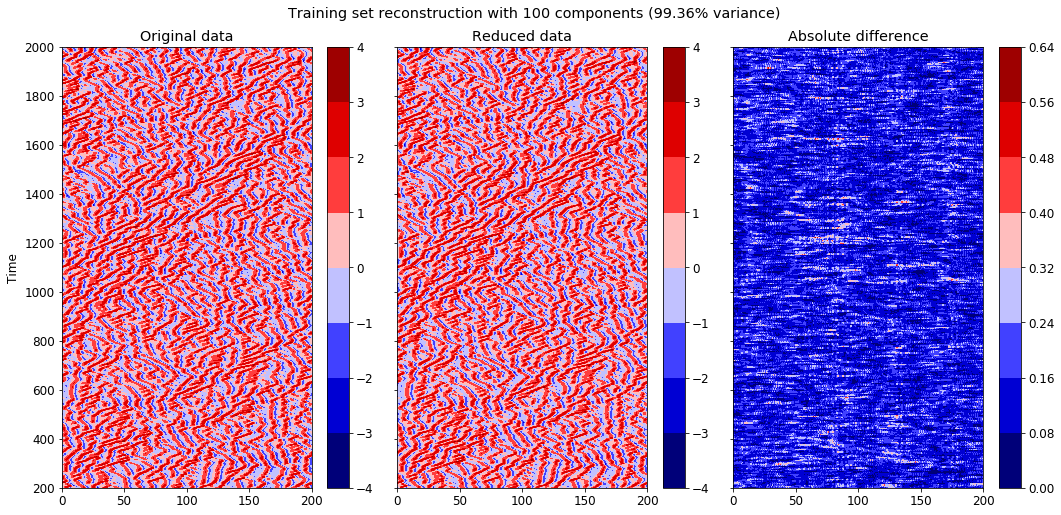

In [31]:
# Original Data
U_original_reconstructed, U_original_projected, PC, variance = PCA_ED(U, k)
plot_data_compare(X, T, U, U_original_reconstructed, k, variance)
POD_error(U, U_original_reconstructed)

**Standardized Data**

Modal energy preserved: 99.36%


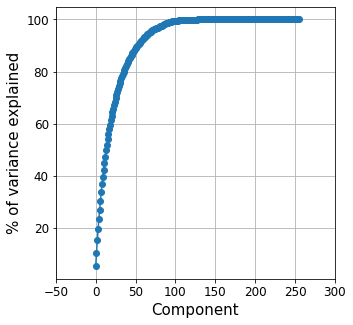

Mean error 0.06
The projection error for POD is 10.04%


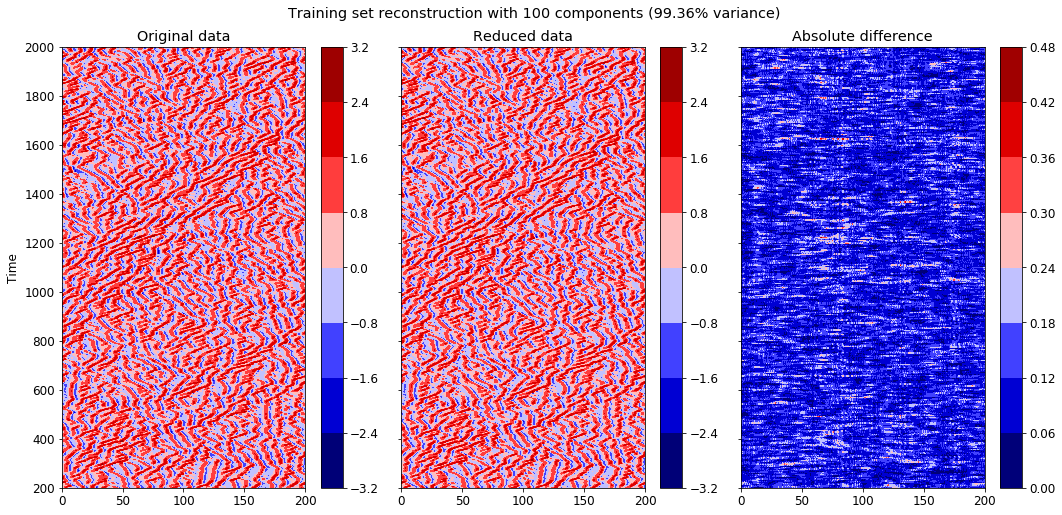

In [32]:
# Standardized Data
U_standardized_reconstructed, U_standardized_projected, PC, variance = PCA_ED(standardize(U), k)
plot_data_compare(X, T, standardize(U), standardize(U_standardized_reconstructed), k, variance)
POD_error(standardize(U), standardize(U_standardized_reconstructed))

**Normalized Data**

Modal energy preserved: 99.37%


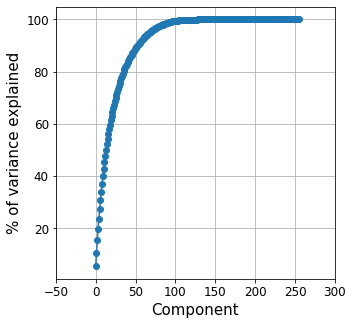

Mean error 0.02
The projection error for POD is 2.24%


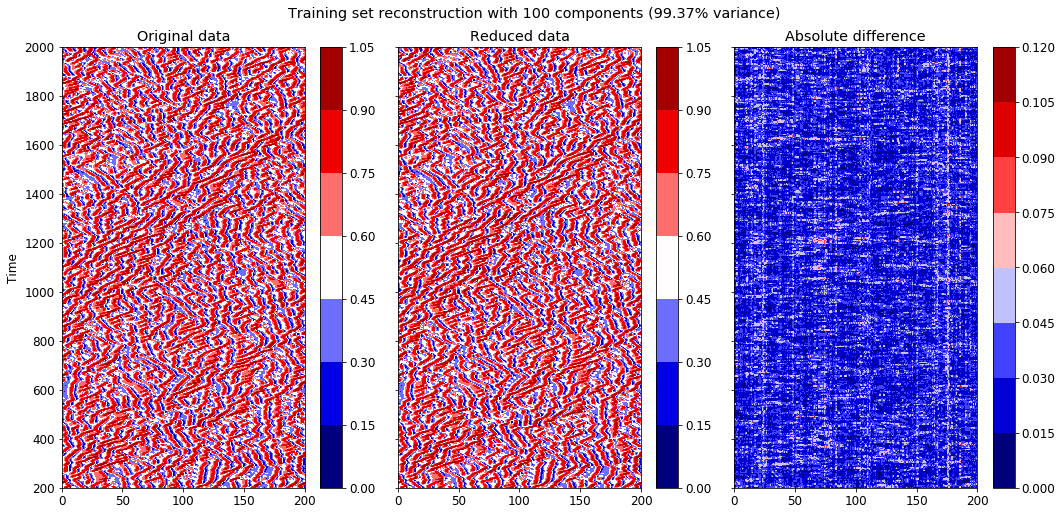

In [33]:
# Normalized Data
U_normalized_reconstructed, U_normalized_projected, PC, variance = PCA_ED(normalize(U), k)
plot_data_compare(X, T, normalize(U), normalize(U_normalized_reconstructed), k, variance)
POD_error(normalize(U), normalize(U_normalized_reconstructed))

## Trainning the Neural Network

### Obtaining the projected U and the modes

In this work, the 100 principal components ($PC_i$ or modes) will be used, which preserve approximately 99.3% of the system variance.

Another important information is that the **original data U** has been **normalized**, being in the **range between 0 and 1**.

In [34]:
k = 100
u_projected, modes, variance = project(normalize(U), k)
print(u_projected.shape)

total_modal_energy: 99.37%
(36001, 100)


### Separating training and test data

90% of the data will be separated for training and the remaining 10% for model validation

In [35]:
# The fraction of data used for training the model.
train_fraction = 0.9
test_fraction = 1 - train_fraction

In [36]:
# Choosing the number of training and testing samples
n_samples = U.shape[0]
train_samples = int(train_fraction * n_samples)
test_samples = n_samples - train_samples
print(train_samples)
print(test_samples)

32400
3601


In [37]:
u_projected_train = u_projected[1:train_samples+1,:]
x_train = X[1:train_samples+1,:]
t_train = T[1:train_samples+1,:]

u_projected_test = u_projected[train_samples+1:,:]
x_test = X[train_samples+1:,:]
t_test = T[train_samples+1:,:]

print(u_projected_train.shape)
print(u_projected_test.shape)

(32400, 100)
(3600, 100)


### Strategy to trainning de neural network

The strategy that is being used for training the neural network is:

- Apply the **POD projection** in the original dataset, and thus obtain the U function with the **reduced space** that **preserves the greatest energy** in the system.

- Once this is done, the data that will compose the neural network input are the $U_{i-1,j}$ (a previous timestep) and the data that will be used as target are $U_{i,j}$ (output of the NN), where this $U$ is the POD projection.

In [38]:
output_data_train = u_projected_train

input_data_train = np.zeros((output_data_train.shape[0], output_data_train.shape[1]))
input_data_train[0,:] = u_projected[0]
input_data_train[1:,:] = u_projected_train[:-1]

input_data_train.shape

(32400, 100)

In [39]:
output_data_test = u_projected_test

input_data_test = np.zeros((output_data_test.shape[0], output_data_test.shape[1]))
input_data_test[0,:] = u_projected_train[-1]
input_data_test[1:,:] = u_projected_test[:-1]

input_data_test.shape

(3600, 100)

In [40]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras import regularizers
from keras.optimizers import SGD, Adam, Nadam, Adadelta
from sklearn.model_selection import train_test_split
import time

### Creating the Neural Network model

In [41]:
# Creating the NN
model = Sequential()
model.add(Dense(200, input_dim=input_data_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(200, kernel_initializer='glorot_uniform', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(output_data_train.shape[1], kernel_initializer='glorot_uniform', activation='linear')) # Out

# Defining the optimizer
optimizer = Adam()

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

### Fitting the model

In [42]:
history = model.fit(input_data_train, output_data_train, epochs=200, batch_size=1000, validation_data=(input_data_test, output_data_test), verbose=1)

Epoch 1/200
33/33 [==============================] - 1s 22ms/step - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.1012 - val_mean_squared_error: 0.1012
Epoch 2/200
33/33 [==============================] - 0s 6ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0601 - val_mean_squared_error: 0.0601
Epoch 3/200
33/33 [==============================] - 0s 7ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 4/200
33/33 [==============================] - 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 5/200
33/33 [==============================] - 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 6/200
33/33 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0207 - val_mean_squared_error: 0.0207
Epoch 7/200
33/33 [==============

## Analysing the training e test curve with relation de epochs number

Looking at the graphs it was possible to notice that the training data had good results with errors of the order of $2 \times 10^{-5}$ and the test data of the order of $3\times 10^{-2}$. It was also noted that the model suffered from overfitting, where the curves haven't walked together along the epochs.

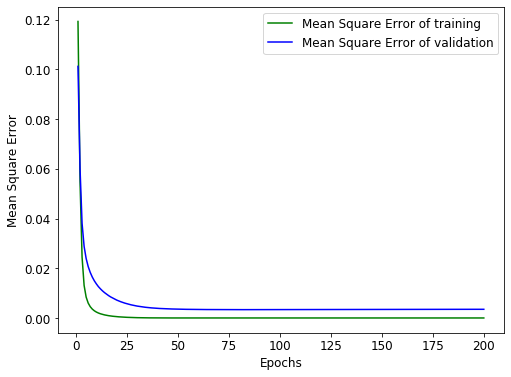

In [43]:
mean_squared_error_train = history.history['mean_squared_error']
mean_squared_error_test = history.history['val_mean_squared_error']

epochs = range(1, len(mean_squared_error_train) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, mean_squared_error_train, '-g', label='Mean Square Error of training')
plt.plot(epochs, mean_squared_error_test, '-b', label='Mean Square Error of validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

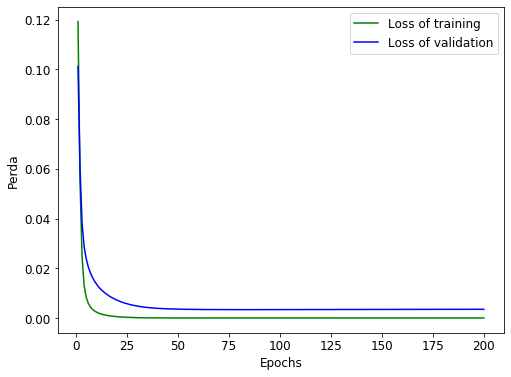

In [44]:
loss_train = history.history['loss']
loss_test = history.history['val_loss']

epochs = range(1, len(loss_train) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, loss_train, '-g', label='Loss of training ')
plt.plot(epochs, loss_test, '-b', label='Loss of validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Perda')
plt.show()

In [45]:
model.save('model_ks.h5')

In [46]:
model = load_model('model_ks.h5')

## Final results

With the **trained model** the $U_{i,j}$ was predicted inputing the $U_{i-1,j}$ and these **reconstructed** with the **modes** of the **POD projection**.

In [47]:
output = model.predict(input_data_test)
output.shape

(3600, 100)

In [48]:
output_reconstructed = reconstruct(output, modes)
output_reconstructed.shape

(3600, 256)

### Plotting the original data U normalized and the predicted and reconstructed data U

Mean error 0.04


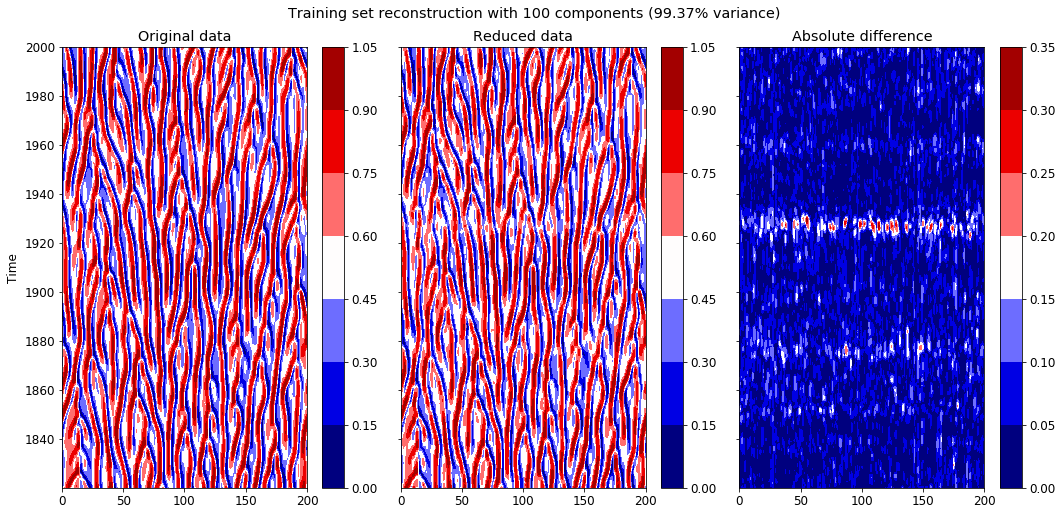

In [49]:
plot_data_compare(x_test, t_test, normalize(U[train_samples+1:]), normalize(output_reconstructed), k, variance)
# plot_data_compare(x_train, t_train, normalize(U[1:train_samples+1]), normalize(output_reconstructed), k, variance)

### Plotting the original time series and the predicted time series

Comparing the orginal time series for the validation data with the predicted time series

**timestep = 0 (the first time serie for the validation data)**

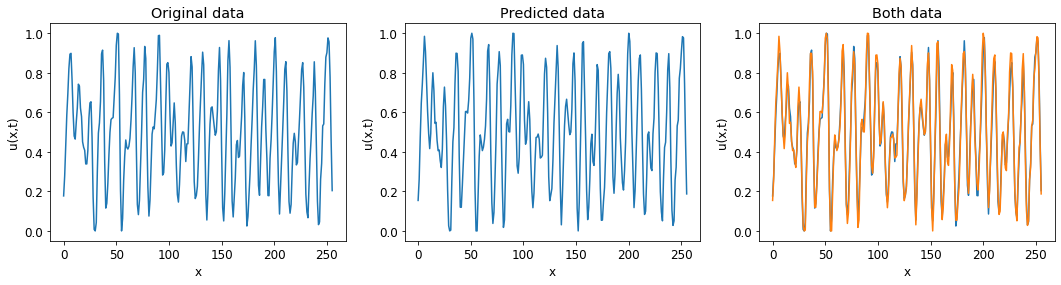

In [50]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=0)
# plot_time_serie(normalize(U[1:train_samples+1]), normalize(output_reconstructed), time=0)

**timestep = 100 (the hundredth time serie for the validation data)**

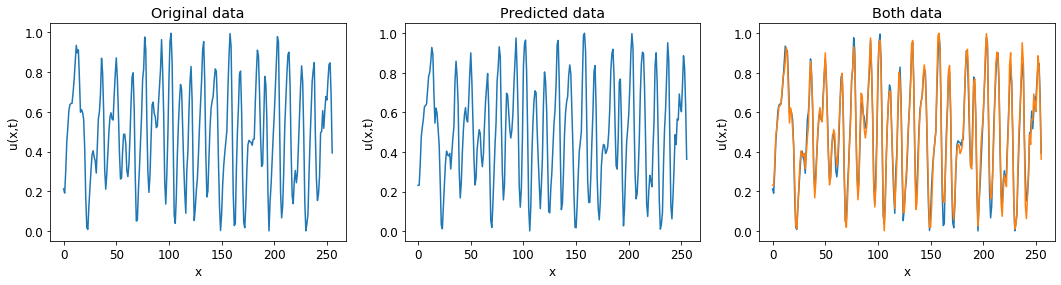

In [51]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=100)

**timestep = 1000 (the thousandth time serie for the validation data)**

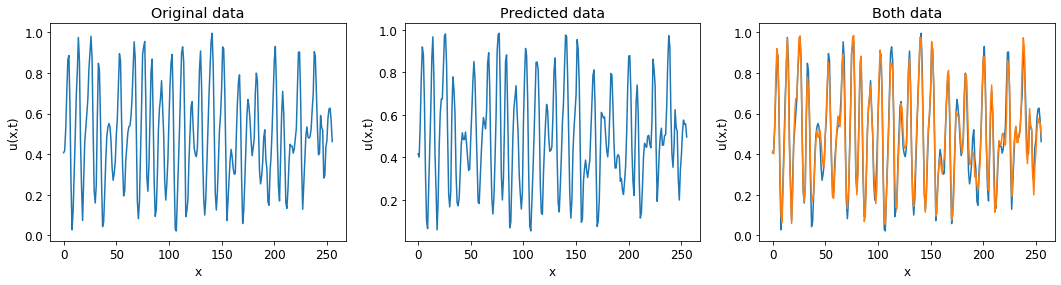

In [52]:
plot_time_serie(normalize(U[train_samples+1:]), normalize(output_reconstructed), time=1000)

### The relative error between the original data U and the predicted and reconstructed data U

In [53]:
POD_error(normalize(U[train_samples+1:]), normalize(output_reconstructed))

The projection error for POD is 4.83%
